In [1]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from tqdm import tqdm
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from joblib import dump
from joblib import load




In [2]:
import os
os.chdir(r"C:\Users\dsala\Downloads")

In [3]:
df=pl.read_parquet("sample_data_0006_part_00.parquet")


In [4]:
df = df.with_columns([
    pl.col("transaction_date").alias("datetime"),
    pl.col("transaction_date").dt.date().alias("date"),
    pl.col("transaction_date").dt.hour().alias("hour"),
    pl.col("transaction_date").dt.weekday().alias("weekday_num")
])

EDA

In [34]:
# Convertir a pandas solo la columna de montos
montos = df.select("transaction_amount").to_pandas()
montos["transaction_amount"] = montos["transaction_amount"].astype(float)

print("Promedio:", montos["transaction_amount"].mean())
print("Mediana:", montos["transaction_amount"].median())
print("Desviación estándar:", montos["transaction_amount"].std())
print("Q25 / Q75:")
print(montos["transaction_amount"].quantile([0.25, 0.75]))


Promedio: 191.39739940787913
Mediana: 107.00019022
Desviación estándar: 240.86328833816557
Q25 / Q75:
0.25     35.66673
0.75    237.77820
Name: transaction_amount, dtype: float64


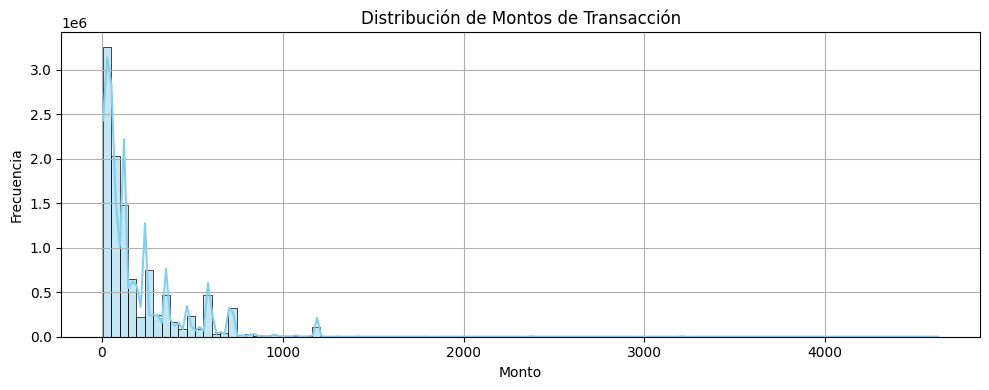

In [6]:


plt.figure(figsize=(10, 4))
sns.histplot(montos["transaction_amount"], bins=100, kde=True, color="skyblue")
plt.title("Distribución de Montos de Transacción")
plt.xlabel("Monto")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()


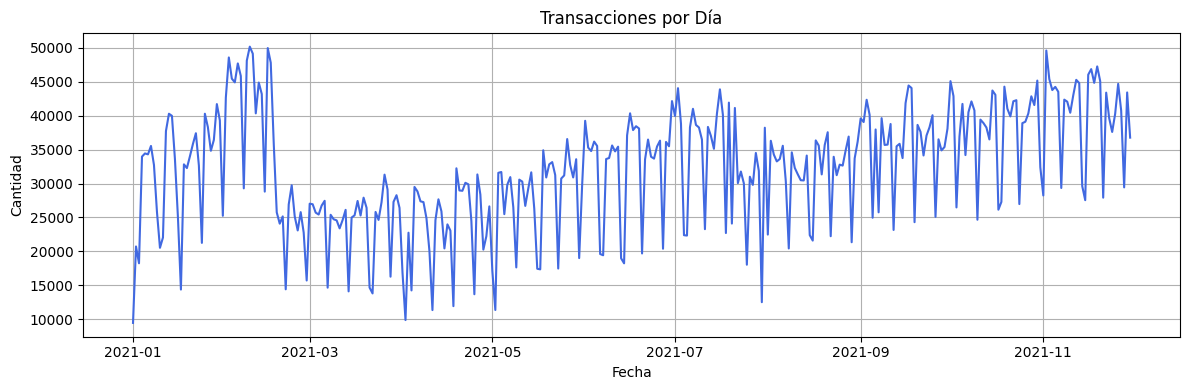

In [7]:
tx_por_dia = df.group_by("date").len().sort("date")
tx_dia_pd = tx_por_dia.to_pandas()
tx_dia_pd["date"] = pd.to_datetime(tx_dia_pd["date"])

plt.figure(figsize=(12, 4))
plt.plot(tx_dia_pd["date"], tx_dia_pd["len"], color="royalblue")
plt.title("Transacciones por Día")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\dsala\AppData\Local\Temp\ipykernel_18732\1957207009.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tx_semana, x="weekday_name", y="len", palette="pastel")


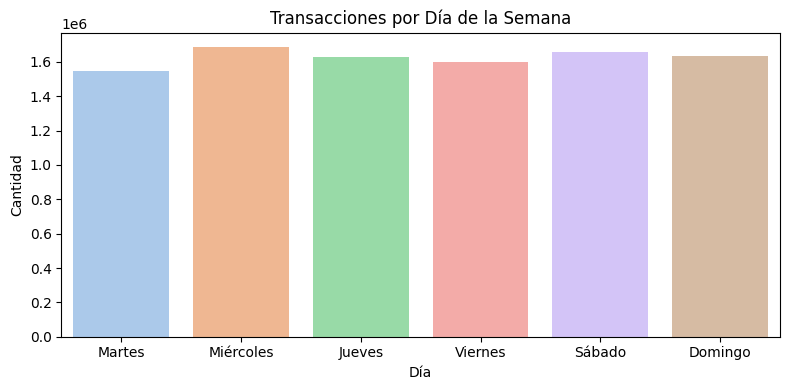

In [8]:
dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
tx_semana = df.group_by("weekday_num").len().sort("weekday_num").to_pandas()
tx_semana["weekday_name"] = tx_semana["weekday_num"].map(dict(enumerate(dias)))

plt.figure(figsize=(8, 4))
sns.barplot(data=tx_semana, x="weekday_name", y="len", palette="pastel")
plt.title("Transacciones por Día de la Semana")
plt.xlabel("Día")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()


C:\Users\dsala\AppData\Local\Temp\ipykernel_18732\2481633818.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tx_hora, x="hour", y="len", palette="viridis")


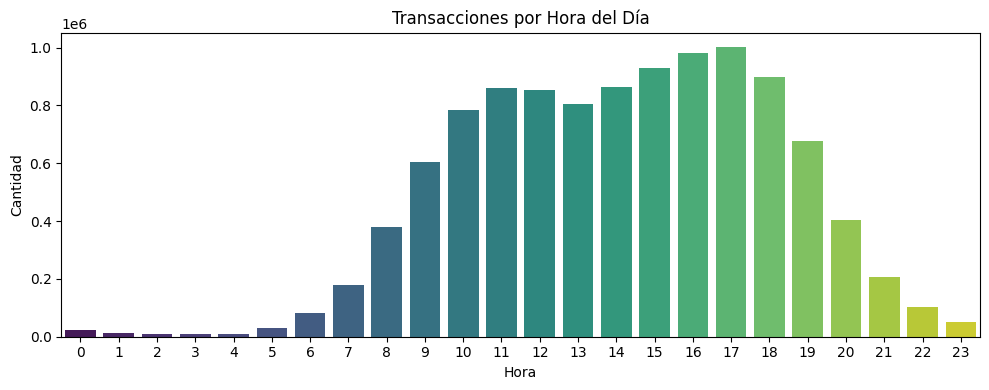

In [9]:
tx_hora = df.group_by("hour").len().sort("hour").to_pandas()

plt.figure(figsize=(10, 4))
sns.barplot(data=tx_hora, x="hour", y="len", palette="viridis")
plt.title("Transacciones por Hora del Día")
plt.xlabel("Hora")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()


Modelo

In [5]:
# Si tienes 'df' en polars, conviértelo a pandas primero
dfp = df.sample(fraction=0.035, seed=202013547).to_pandas()
dfp["datetime"] = pd.to_datetime(dfp["transaction_date"])
dfp = dfp.sort_values(["user_id", "datetime"])


In [6]:
resultados = []

for user, grupo in tqdm(dfp.groupby("user_id")):
    times = grupo["datetime"]
    cuentas = grupo["account_number"]
    montos = grupo["transaction_amount"]

    for i in range(len(grupo)):
        t_actual = times.iloc[i]
        ventana = grupo[
            (times >= t_actual - pd.Timedelta(hours=24)) &
            (times <= t_actual)
        ]
        resultados.append({
            "user_id": user,
            "datetime": t_actual,
            "n_tx_24h": len(ventana),
            "total_24h": ventana["transaction_amount"].sum(),
            "n_cuentas_distintas_24h": ventana["account_number"].nunique()
        })

rolling_df = pd.DataFrame(resultados)

# Etiqueta
rolling_df["sospechoso_24h"] = (
    (rolling_df["n_tx_24h"] >= 2) &
    (rolling_df["total_24h"] >= 100) &
    (rolling_df["n_cuentas_distintas_24h"] <= 2)
)



100%|██████████| 279256/279256 [04:14<00:00, 1098.92it/s]


In [7]:
len(rolling_df[rolling_df["sospechoso_24h"] == True])

2109

In [10]:
# Hora, día, fecha
dfp["hour"] = dfp["datetime"].dt.hour
dfp["weekday"] = dfp["datetime"].dt.weekday
dfp["date"] = dfp["datetime"].dt.date

# Estadísticas por usuario
dfp["transaction_amount"] = dfp["transaction_amount"].astype(float)
grouped = dfp.groupby("user_id")
dfp["n_tx_total"] = grouped["datetime"].transform("count")
dfp["n_cuentas_distintas"] = grouped["account_number"].transform("nunique")
dfp["n_subsidiarias"] = grouped["subsidiary"].transform("nunique")
dfp["monto_promedio_usuario"] = grouped["transaction_amount"].transform("mean")
dfp["std_monto_usuario"] = grouped["transaction_amount"].transform("std")

# Tiempo entre transacciones
dfp = dfp.sort_values(["user_id", "datetime"])
dfp["time_diff"] = grouped["datetime"].diff().dt.total_seconds().fillna(999999)

# Transacciones en la misma hora
dfp["tx_same_hour"] = dfp.groupby(["user_id", "date", "hour"])["transaction_amount"].transform("count")
dfp["tx_same_hour_flag"] = (dfp["tx_same_hour"] > 1).astype(int)

# Proporción de transacciones pequeñas (<250)
dfp["small_tx"] = (dfp["transaction_amount"] < 250).astype(int)
dfp["small_tx_ratio"] = grouped["small_tx"].transform("mean")

# Diferencia absoluta entre montos
dfp["abs_diff_amount"] = grouped["transaction_amount"].diff().abs().fillna(0)
dfp["mean_abs_diff_amount"] = grouped["abs_diff_amount"].transform("mean")


In [11]:
rolling_df["datetime"] = pd.to_datetime(rolling_df["datetime"])
dfp = dfp.merge(
    rolling_df[["user_id", "datetime", "sospechoso_24h"]],
    on=["user_id", "datetime"],
    how="inner"
)


In [12]:
features = [
    "transaction_amount", "hour", "weekday", "time_diff",
    "n_tx_total", "n_cuentas_distintas", "n_subsidiarias",
    "monto_promedio_usuario", "std_monto_usuario",
    "tx_same_hour_flag", "small_tx_ratio", "mean_abs_diff_amount"
]

X = dfp[features].astype(float)
y = dfp["sospechoso_24h"]

# Reemplazar NaNs
X = X.fillna(X.median(numeric_only=True))


In [13]:


# Modelo
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=202013547
)

# Pipeline con SMOTE dentro (así se aplica correctamente en cada fold)
pipeline = ImbPipeline([
    ("smote", SMOTE(random_state=202013547)),
    ("clf", xgb)
])

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=202013547)

# Evaluar múltiples métricas
for metric in ["f1", "recall", "precision", "roc_auc"]:
    scores = cross_val_score(pipeline, X, y, scoring=metric, cv=cv, n_jobs=-1)
    print(f"{metric.upper()} scores: {scores}")
    print(f"Promedio {metric}: {scores.mean():.4f}\n")


F1 scores: [0.97630332 0.96713615 0.96955504 0.96055684 0.95215311 0.96190476
 0.96470588 0.94663573 0.96470588 0.95150115]
Promedio f1: 0.9615

RECALL scores: [0.97630332 0.97630332 0.98104265 0.98104265 0.94761905 0.95734597
 0.97156398 0.96682464 0.97156398 0.97630332]
Promedio recall: 0.9706

PRECISION scores: [0.97630332 0.95813953 0.95833333 0.94090909 0.95673077 0.96650718
 0.95794393 0.92727273 0.95794393 0.92792793]
Promedio precision: 0.9528

ROC_AUC scores: [0.99998443 0.99996456 0.99998266 0.99997393 0.99988478 0.99993735
 0.99995747 0.99994621 0.99997949 0.99984077]
Promedio roc_auc: 0.9999



In [14]:

pipeline.fit(X, y)

# Guardar todo el pipeline (SMOTE + XGB)
dump(pipeline, "pipeline_fraccionamiento.pkl")

print(" Pipeline completo guardado como pipeline_fraccionamiento.pkl")


 Pipeline completo guardado como pipeline_fraccionamiento.pkl


Prueba de predicción en muestra representativa de la base

In [15]:
df_sample = df.sample(n=150000, seed=12345)


In [ ]:
# Hora, día, fecha
df_sample = df_sample.with_columns([
    pl.col("datetime").dt.hour().alias("hour"),
    pl.col("datetime").dt.weekday().alias("weekday"),
    pl.col("datetime").dt.date().alias("date")
])

# n_tx_total
n_tx_total = df_sample.group_by("user_id").agg(
    pl.len().alias("n_tx_total")
)

# n_cuentas_distintas
n_cuentas_distintas = df_sample.group_by("user_id").agg(
    pl.col("account_number").n_unique().alias("n_cuentas_distintas")
)

# n_subsidiarias
n_subsidiarias = df_sample.group_by("user_id").agg(
    pl.col("subsidiary").n_unique().alias("n_subsidiarias")
)

# Promedio y desviación estándar del monto
monto_stats = df_sample.group_by("user_id").agg([
    pl.col("transaction_amount").mean().alias("monto_promedio_usuario"),
    pl.col("transaction_amount").std().alias("std_monto_usuario")
])

# Transacciones pequeñas
df_sample = df_sample.with_columns([
    (pl.col("transaction_amount") < 250).cast(pl.Int8).alias("small_tx")
])

# Ratio de transacciones pequeñas por usuario
small_tx_ratio = df_sample.group_by("user_id").agg(
    pl.col("small_tx").mean().alias("small_tx_ratio")
)

# Flag por transacciones en misma hora
df_sample = df_sample.with_columns([
    (pl.col("date").cast(pl.Utf8) + "_" + pl.col("hour").cast(pl.Utf8)).alias("date_hour")
])

same_hour_counts = df_sample.group_by(["user_id", "date_hour"]).agg(
    pl.len().alias("tx_same_hour")
)

df_sample = df_sample.join(same_hour_counts, on=["user_id", "date_hour"], how="left").with_columns([
    (pl.col("tx_same_hour") > 1).cast(pl.Int8).alias("tx_same_hour_flag")
])
# Ordenar por usuario y fecha
df_sample = df_sample.sort(["user_id", "datetime"])

# Diferencia de tiempo entre transacciones
df_sample = df_sample.with_columns([
  (
    pl.col("datetime")
    .diff()
    .over("user_id")
    .dt.total_nanoseconds()
    .cast(pl.Float64) / 1e9  
).fill_null(999999).alias("time_diff")


])

# Diferencia absoluta entre montos
df_sample = df_sample.with_columns([
    pl.col("transaction_amount").diff().abs().over("user_id").fill_null(0).alias("abs_diff_amount")
])

# Promedio de diferencia de montos por usuario
mean_abs_diff = df_sample.group_by("user_id").agg(
    pl.col("abs_diff_amount").mean().alias("mean_abs_diff_amount")
)

# Unir al dataframe
df_sample = df_sample.join(mean_abs_diff, on="user_id", how="left")


################## Hay que correr este chunk 3 veces para que se genere el df_sample final aunque muestre error, no hay que cambiar nada.

In [17]:
df_sample = df_sample.join(n_tx_total, on="user_id", how="left")
df_sample = df_sample.join(n_cuentas_distintas, on="user_id", how="left")
df_sample = df_sample.join(n_subsidiarias, on="user_id", how="left")
df_sample = df_sample.join(monto_stats, on="user_id", how="left")
df_sample = df_sample.join(small_tx_ratio, on="user_id", how="left")


In [18]:
features = [
    "transaction_amount", "hour", "weekday", "time_diff",
    "n_tx_total", "n_cuentas_distintas", "n_subsidiarias",
    "monto_promedio_usuario", "std_monto_usuario",
    "tx_same_hour_flag", "small_tx_ratio", "mean_abs_diff_amount"
]


X_full = df_sample.select(["user_id"] + features)


In [19]:
X_pd = X_full.select(features).to_pandas().astype(float)
user_ids = X_full["user_id"].to_pandas()


In [20]:


pipeline = load("pipeline_fraccionamiento.pkl")
y_pred = pipeline.predict(X_pd)


In [26]:

result_df = pd.DataFrame({
    "user_id": user_ids,
    "sospechoso_predicho": y_pred
})

# Exportar todos
result_df.to_csv("predicciones_muestra.csv", index=False)

# Exportar solo sospechosos
trans_sospechosas = result_df[result_df["sospechoso_predicho"] == 1]
trans_sospechosas.to_csv("usuarios_sospechosos_muestra.csv", index=False)
usuarios_sospechosos = trans_sospechosas["user_id"].nunique()
print(f" Se detectaron {usuarios_sospechosos} usuarios  con {len(trans_sospechosas)} casos de transferencias fraccionadas en la muestra de 150.000 transacciones.")





 Se detectaron 310 usuarios  con 314 casos de transferencias fraccionadas en la muestra de 150.000 transacciones.
